In [1]:
from tensorflow.keras.applications import VGG16

In [2]:
conv_base = VGG16(weights = 'imagenet',
                  include_top = False,
                  input_shape = (150,150,3))

58892288/58889256 [==============================] - 7s 0us/step


In [3]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

## Fast feature extraction without data augmentation

In [4]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
base_dir = '/home/tuffy/Documents/CholletDL/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

In [8]:
def extract_features(directory, sample_count):
    features = np.zeros(shape = (sample_count, 4, 4, 512))
    labels = np.zeros(shape= (sample_count))
    generator = datagen.flow_from_directory(directory, 
                                            target_size = (150,150),
                                            batch_size = batch_size,
                                            class_mode = 'binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i*batch_size : (i+1)*batch_size] = features_batch
        labels[i * batch_size : (i+1)*batch_size] = labels_batch
        i +=1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [9]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

train_features = np.reshape(train_features, (2000, 4 * 4* 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4* 512))
test_features = np.reshape(test_features, (1000, 4* 4* 512))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [10]:
from tensorflow.keras import models, layers, optimizers

In [11]:
model = models.Sequential()
model.add(layers.Dense(256, activation = 'relu',input_dim = 4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [12]:
model.compile(optimizer = optimizers.RMSprop(lr = 2e-5),
             loss = 'binary_crossentropy',
             metrics = ['acc'])

In [14]:
history = model.fit(train_features, train_labels, epochs = 30, batch_size = 20,
                   validation_data = (validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 5s 48ms/step - loss: 0.5768 - acc: 0.6945 - val_loss: 0.4385 - val_acc: 0.8310
Epoch 2/30
100/100 [==============================] - 4s 36ms/step - loss: 0.4127 - acc: 0.8135 - val_loss: 0.3584 - val_acc: 0.8650
Epoch 3/30
100/100 [==============================] - 3s 29ms/step - loss: 0.3561 - acc: 0.8385 - val_loss: 0.3218 - val_acc: 0.8740
Epoch 4/30
100/100 [==============================] - 3s 27ms/step - loss: 0.3070 - acc: 0.8700 - val_loss: 0.3005 - val_acc: 0.8880
Epoch 5/30
100/100 [==============================] - 3s 27ms/step - loss: 0.2793 - acc: 0.8845 - val_loss: 0.2853 - val_acc: 0.8870
Epoch 6/30
100/100 [==============================] - 3s 27ms/step - loss: 0.2477 - acc: 0.8980 - val_loss: 0.2808 - val_acc: 0.8820
Epoch 7/30
100/100 [==============================] - 3s 25ms/step - loss: 0.2468 - acc: 0.9025 - val_loss: 0.2674 - val_acc: 0.8930
Epoch 8/30
100/100 [==============================] - 3s 26ms/step - 

In [13]:
import matplotlib.pyplot as plt

def plotAccLoss(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label = 'Training acc')
    plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    
    plt.figure()
    
    plt.plot(epochs, loss, 'bo', label = 'Training acc')
    plt.plot(epochs, val_loss, 'b', label = 'Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    
    plt.show()

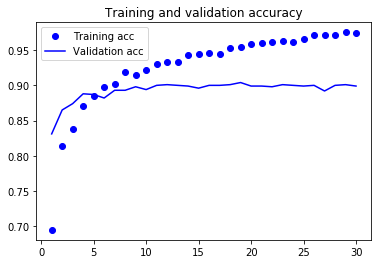

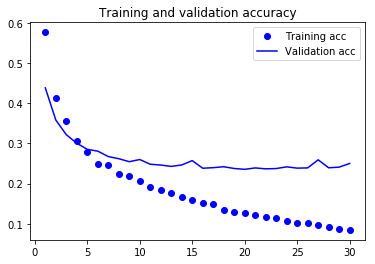

In [15]:
plotAccLoss(history)

## Feature extraction with data augmentation

In [16]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


### Freezing a layer

In [18]:
print('This is the number of trainable weights before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('This is the number of trainable weights after freezing the conv base:', len(model.trainable_weights))


This is the number of trainable weights before freezing the conv base: 30
This is the number of trainable weights after freezing the conv base: 4


In [19]:
def GetGenerator(batch_size):
    train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range= 0.2,
                                  shear_range=0.2,
                                  zoom_range =0.2,
                                  horizontal_flip = True, 
                                  fill_mode = 'nearest')
    
    test_datagen = ImageDataGenerator(rescale = 1./255)
    
    train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size = (150,150), 
                                                    batch_size = batch_size,
                                                    class_mode = 'binary')
    validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                    target_size = (150,150), 
                                                    batch_size = batch_size,
                                                    class_mode = 'binary')
    return train_generator, validation_generator

In [20]:
train_gen, validation_gen = GetGenerator(20)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [21]:
model.compile(loss = 'binary_crossentropy',
             optimizer= optimizers.RMSprop(lr = 2e-5),
             metrics=['acc'])

In [22]:
history = model.fit(train_gen, 
                   steps_per_epoch = 100,
                   epochs = 30,
                   validation_data = validation_gen,
                   validation_steps = 50)

Epoch 1/30
100/100 [==============================] - 202s 2s/step - loss: 0.5902 - acc: 0.6890 - val_loss: 0.4429 - val_acc: 0.8240
Epoch 2/30
100/100 [==============================] - 200s 2s/step - loss: 0.4738 - acc: 0.7910 - val_loss: 0.3654 - val_acc: 0.8560
Epoch 3/30
100/100 [==============================] - 200s 2s/step - loss: 0.4243 - acc: 0.8180 - val_loss: 0.3251 - val_acc: 0.8730
Epoch 4/30
100/100 [==============================] - 200s 2s/step - loss: 0.4007 - acc: 0.8285 - val_loss: 0.3075 - val_acc: 0.8740
Epoch 5/30
100/100 [==============================] - 200s 2s/step - loss: 0.3793 - acc: 0.8285 - val_loss: 0.2902 - val_acc: 0.8880
Epoch 6/30
100/100 [==============================] - 200s 2s/step - loss: 0.3667 - acc: 0.8335 - val_loss: 0.2871 - val_acc: 0.8840
Epoch 7/30
100/100 [==============================] - 200s 2s/step - loss: 0.3567 - acc: 0.8480 - val_loss: 0.2696 - val_acc: 0.8880
Epoch 8/30
100/100 [==============================] - 200s 2s/step - 

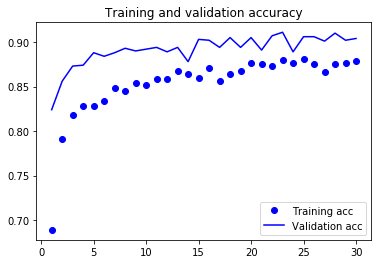

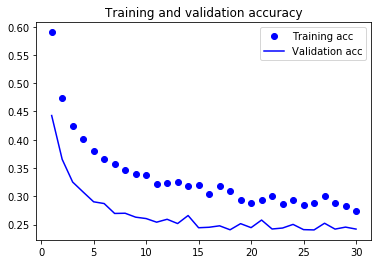

In [23]:
plotAccLoss(history)

In [35]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [36]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy',
             optimizer = optimizers.RMSprop(lr = 1e-5),
             metrics = ['acc'])

In [37]:
history = model.fit(train_gen, 
                    steps_per_epoch= 100,
                    epochs = 30,
                    validation_data = validation_gen, 
                    validation_steps = 50)

Epoch 1/30
100/100 [==============================] - 231s 2s/step - loss: 0.3769 - acc: 0.8500 - val_loss: 0.2167 - val_acc: 0.9120
Epoch 2/30
100/100 [==============================] - 230s 2s/step - loss: 0.2179 - acc: 0.9140 - val_loss: 0.1721 - val_acc: 0.9280
Epoch 3/30
100/100 [==============================] - 230s 2s/step - loss: 0.1823 - acc: 0.9240 - val_loss: 0.1683 - val_acc: 0.9300
Epoch 4/30
100/100 [==============================] - 230s 2s/step - loss: 0.1563 - acc: 0.9385 - val_loss: 0.1675 - val_acc: 0.9300
Epoch 5/30
100/100 [==============================] - 230s 2s/step - loss: 0.1419 - acc: 0.9460 - val_loss: 0.1928 - val_acc: 0.9240
Epoch 6/30
100/100 [==============================] - 230s 2s/step - loss: 0.1187 - acc: 0.9520 - val_loss: 0.1527 - val_acc: 0.9310
Epoch 7/30
100/100 [==============================] - 230s 2s/step - loss: 0.1240 - acc: 0.9535 - val_loss: 0.1977 - val_acc: 0.9260
Epoch 8/30
100/100 [==============================] - 230s 2s/step - 

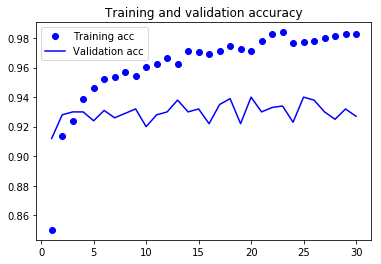

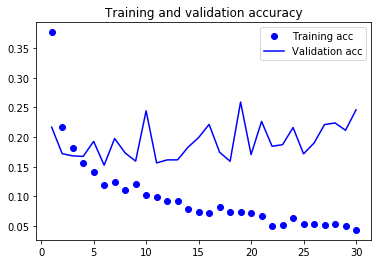

In [38]:
plotAccLoss(history)

In [28]:
def smooth_curve(points, factor = 0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

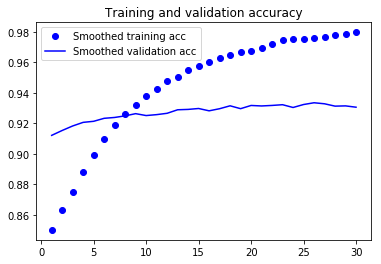

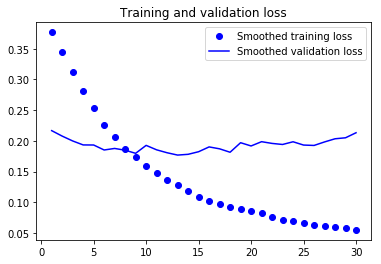

In [39]:
epochs = range(1, len(history.history['acc']) + 1)

plt.plot(epochs, smooth_curve(history.history['acc']), 'bo', label = 'Smoothed training acc')
plt.plot(epochs, smooth_curve(history.history['val_acc']), 'b', label = 'Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, smooth_curve(history.history['loss']), 'bo', label = 'Smoothed training loss')
plt.plot(epochs, smooth_curve(history.history['val_loss']), 'b', label = 'Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

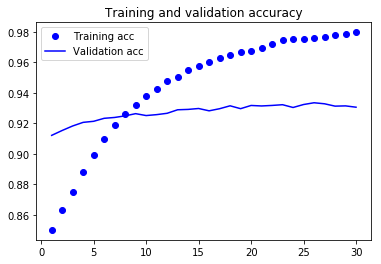

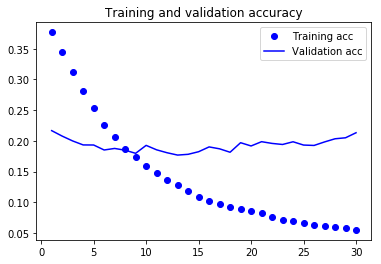

In [41]:
from util import myplot
myplot.plotAccLossSmooth(history)

In [40]:
test_datagen = ImageDataGenerator(rescale = 1./255)
    
test_generator = test_datagen.flow_from_directory(test_dir,
                                                 target_size =(150,150),
                                                 batch_size = 20,
                                                 class_mode = 'binary')

test_loss, test_acc = model.evaluate(test_generator, steps = 50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
Instructions for updating:
Please use Model.evaluate, which supports generators.
test acc: 0.9369999766349792
